<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.981 · TFM · Aula 1</p>
<p style="margin: 0; text-align:right;">2024-2 · Màster universitari en Ciència de dades (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis d'informàtica, multimèdia i telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>
<div style="text-align: center; margin-top: 40px;">
    <h1>Aplicación para ayuda a la conducción con deep learning</h1>
</div>

### ARCHIVO 12: Pruebas detección de frenos

Código que pone a prueba los modelos entrenados anteriormente con imágenes de archivo.

Código ejecutado en plataforma Visual Studio Code.

In [1]:
# Llibreries

from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

In [7]:
# Models

model_det = YOLO("Models/Detectvehicles.pt")        # Model que detecta cotxes i motos
model_seg = YOLO("Models/CarSegment.pt")            # Model que segmenta cotxes
model_bra = torch.load("Models/DetectBrake.pt")    # Model decisió binària fre.
model_bra = model_bra.cuda().eval()

# Transformació per model_bra
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


0: 480x640 4 cars, 63.1ms
Speed: 12.5ms preprocess, 63.1ms inference, 397.0ms postprocess per image at shape (1, 3, 480, 640)


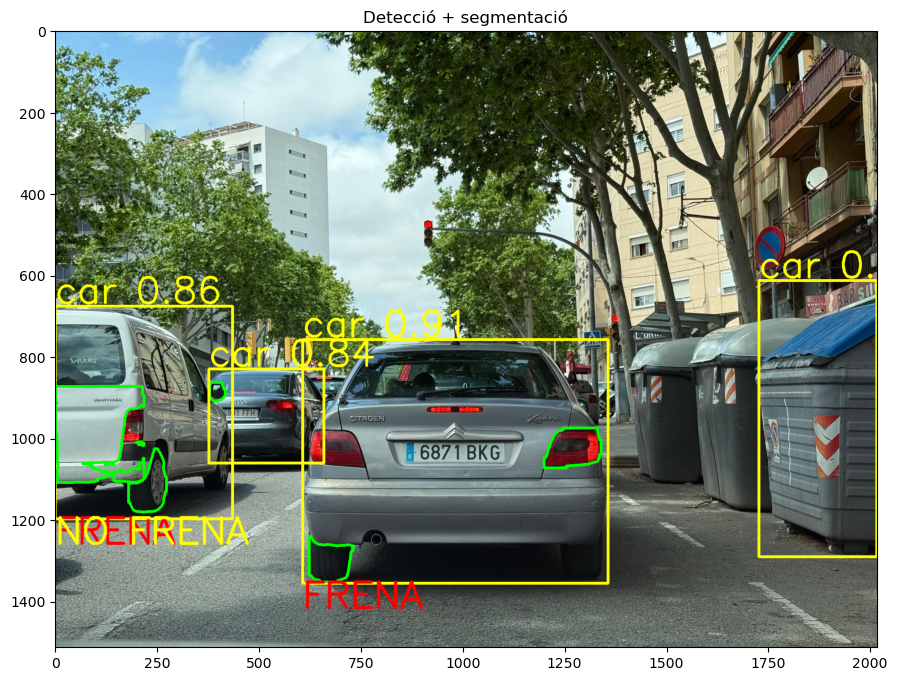

In [3]:
# Imatge a tractar
frame = cv2.imread("5.jpg")

# Detecció
results_det = model_det(frame)[0]

# Per detecció mostra per pantalla
for box in results_det.boxes:

    cls = int(box.cls[0])
    label = model_det.names[cls]
    conf = box.conf[0]
    
    # Coordenades
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    x1, y1 = max(x1, 0), max(y1, 0)
    x2, y2 = min(x2, frame.shape[1]), min(y2, frame.shape[0])

    # bbox + text
    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 255), 5)
    label_text = f"{label} {conf:.2f}"
    cv2.putText(frame, label_text, (x1, y1 - 8),
                cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 255), 5)

    # Segmentació
    roi = frame[y1:y2, x1:x2] # ROI = Region of interest anomenat a la segmentació, regió de la imatge
    results_seg = model_seg(roi, conf=0.25, iou=0.4, verbose=False)[0]

    if results_seg.masks is not None: # Si segmenta, es mostren els resultats
        for i, mask in enumerate(results_seg.masks.data):
            if i == 4 or i == 7 or i == 5: # Únicament si són llums posteriors
                mask_np = mask.cpu().numpy().astype("uint8") * 255
                mask_resized = cv2.resize(mask_np, (x2 - x1, y2 - y1))
                                
                # Contorn
                contours, _ = cv2.findContours(mask_resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                cv2.drawContours(roi, contours, -1, (0, 255, 0), 5) # Verd
                
                # Retalla part segmentada
                seg_img = roi.copy()
                seg_img[mask_resized == 0] = 0

                # Prepara per inferència
                input_img = cv2.cvtColor(seg_img, cv2.COLOR_BGR2RGB)
                input_img = cv2.resize(input_img, (224, 224))
                input_tensor = transform(input_img).unsqueeze(0).cuda()

                # Determina si frena o no
                with torch.no_grad():
                    output = model_bra(input_tensor)
                    prob = torch.sigmoid(output).item()
                    frenada = prob > 0.5

                # Mostra resultat
                status_text = "FRENA" if frenada else "NO FRENA"
                color = (0, 0, 255) if frenada else (0, 255, 255)
                cv2.putText(frame, status_text, (x1, y2 + 60),
                            cv2.FONT_HERSHEY_SIMPLEX, 3, color, 6, cv2.LINE_AA)

# Correcció BGR a RGB
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Mostra la imatge
plt.figure(figsize=(12, 8))
plt.imshow(frame_rgb)
plt.title("Detecció + segmentació")
plt.show()


0: 480x640 5 cars, 18.1ms
Speed: 3.4ms preprocess, 18.1ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


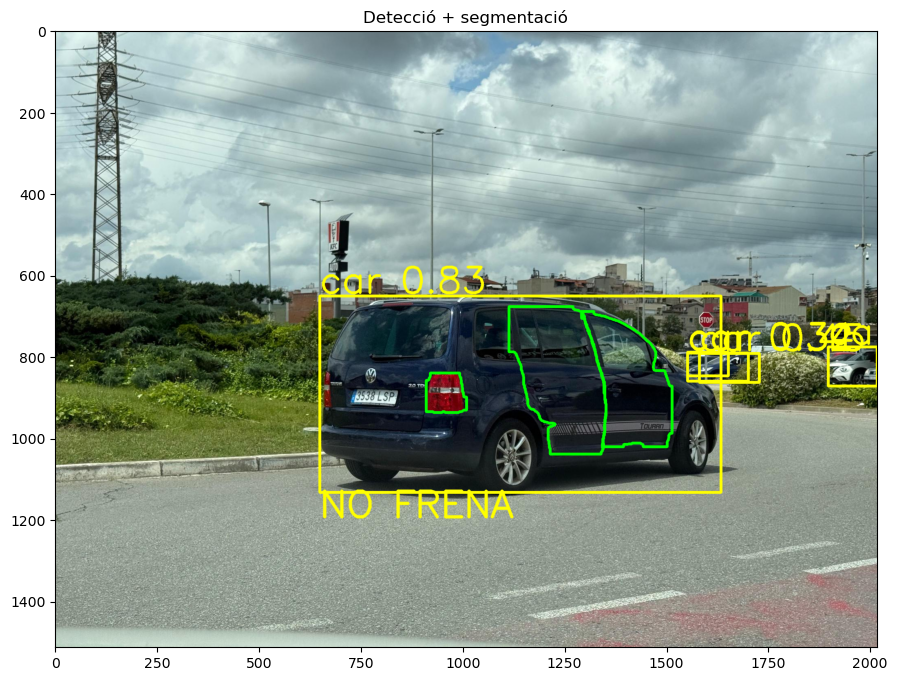

In [8]:
# Imatge a tractar
frame = cv2.imread("foto1.jpg")

# Detecció
results_det = model_det(frame)[0]

# Per detecció mostra per pantalla
for box in results_det.boxes:

    cls = int(box.cls[0])
    label = model_det.names[cls]
    conf = box.conf[0]
    
    # Coordenades
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    x1, y1 = max(x1, 0), max(y1, 0)
    x2, y2 = min(x2, frame.shape[1]), min(y2, frame.shape[0])

    # bbox + text
    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 255), 5)
    label_text = f"{label} {conf:.2f}"
    cv2.putText(frame, label_text, (x1, y1 - 8),
                cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 255), 5)

    # Segmentació
    roi = frame[y1:y2, x1:x2] # ROI = Region of interest anomenat a la segmentació, regió de la imatge
    results_seg = model_seg(roi, conf=0.25, iou=0.4, verbose=False)[0]

    if results_seg.masks is not None: # Si segmenta, es mostren els resultats
        for i, mask in enumerate(results_seg.masks.data):
            if i == 4 or i == 7 or i == 5: # Únicament si són llums posteriors
                mask_np = mask.cpu().numpy().astype("uint8") * 255
                mask_resized = cv2.resize(mask_np, (x2 - x1, y2 - y1))
                                
                # Contorn
                contours, _ = cv2.findContours(mask_resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                cv2.drawContours(roi, contours, -1, (0, 255, 0), 5) # Verd
                
                # Retalla part segmentada
                seg_img = roi.copy()
                seg_img[mask_resized == 0] = 0

                # Prepara per inferència
                input_img = cv2.cvtColor(seg_img, cv2.COLOR_BGR2RGB)
                input_img = cv2.resize(input_img, (224, 224))
                input_tensor = transform(input_img).unsqueeze(0).cuda()

                # Determina si frena o no
                with torch.no_grad():
                    output = model_bra(input_tensor)
                    prob = torch.sigmoid(output).item()
                    frenada = prob > 0.5

                # Mostra resultat
                status_text = "FRENA" if frenada else "NO FRENA"
                color = (0, 0, 255) if frenada else (0, 255, 255)
                cv2.putText(frame, status_text, (x1, y2 + 60),
                            cv2.FONT_HERSHEY_SIMPLEX, 3, color, 6, cv2.LINE_AA)

# Correcció BGR a RGB
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Mostra la imatge
plt.figure(figsize=(12, 8))
plt.imshow(frame_rgb)
plt.title("Detecció + segmentació")
plt.show()

In [ ]:
# Vídeo a tractar
video_path = "Media/v2.mp4"
cap = cv2.VideoCapture(video_path)

# Sortida
out = cv2.VideoWriter("sortida_segmentadav4.mp4",
                      cv2.VideoWriter_fourcc(*'mp4v'),
                      cap.get(cv2.CAP_PROP_FPS),
                      (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

# Per fotograma
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # DETECCIÓ de vehicles
    results_det = model_det(frame)[0]

    # Per detecció mostra per pantalla
    for box in results_det.boxes:

        cls = int(box.cls[0])
        label = model_det.names[cls]
        conf = box.conf[0]
    
        # Coordenades
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        x1, y1 = max(x1, 0), max(y1, 0)
        x2, y2 = min(x2, frame.shape[1]), min(y2, frame.shape[0])

        # bbox + text
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 255), 2)
        label_text = f"{label} {conf:.2f}"
        cv2.putText(frame, label_text, (x1, y1 - 8),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

        # Segmentació
        roi = frame[y1:y2, x1:x2] # ROI = Region of interest anomenat a la segmentació, regió de la imatge
        results_seg = model_seg(roi, verbose=False)[0]

        if results_seg.masks is not None: # Si segmenta, es mostren els resultats
            for i, mask in enumerate(results_seg.masks.data):
                if i == 4 or i == 7 or i == 5: # Únicament si són llums posteriors
                    mask_np = mask.cpu().numpy().astype("uint8") * 255
                    mask_resized = cv2.resize(mask_np, (x2 - x1, y2 - y1))
  
                    # Contorn
                    contours, _ = cv2.findContours(mask_resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    cv2.drawContours(roi, contours, -1, (0, 255, 0), 2) # Verd
                    
                    # Retalla part segmentada
                    seg_img = roi.copy()
                    seg_img[mask_resized == 0] = 0

                    # Prepara per inferència
                    input_img = cv2.cvtColor(seg_img, cv2.COLOR_BGR2RGB)
                    input_img = cv2.resize(input_img, (224, 224))
                    input_tensor = transform(input_img).unsqueeze(0).cuda()

                    # Determina si frena o no
                    with torch.no_grad():
                        output = model_bra(input_tensor)
                        prob = torch.sigmoid(output).item()
                        frenada = prob > 0.5

                    # Mostra resultat
                    status_text = "FRENA" if frenada else "NO FRENA"
                    color = (0, 0, 255) if frenada else (0, 255, 255)
                    cv2.putText(frame, status_text, (x1, y2 + 60),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)

    # Escriu el frame al vídeo sortida
    out.write(frame)

# Tanca arxiu
cap.release()
out.release()
cv2.destroyAllWindows()


0: 384x640 4 cars, 164.3ms
Speed: 13.6ms preprocess, 164.3ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 17.4ms
Speed: 2.7ms preprocess, 17.4ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 20.0ms
Speed: 2.2ms preprocess, 20.0ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 15.7ms
Speed: 2.0ms preprocess, 15.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 16.1ms
Speed: 2.1ms preprocess, 16.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 19.3ms
Speed: 2.0ms preprocess, 19.3ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 16.2ms
Speed: 2.6ms preprocess, 16.2ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 14.9ms
Speed: 2.2ms preprocess, 14.9ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 3

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1295: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'
